In [1]:
import os
from google.colab import drive
import tarfile
import pickle
import json


from matplotlib import colors, pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path #Для элегантной работы с ссылками на файлы

import numpy as np
from torchvision import transforms
from PIL import Image
import torch
# from skimage import io
import copy
from sklearn.metrics import f1_score, accuracy_score

from tqdm import tqdm, tqdm_notebook
import torch.nn as nn

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
# Разархивация данных
tf = tarfile.open("/content/gdrive/My Drive/intership/internship_data.tar.gz")
tf.extractall()

In [3]:
# Константы для обучения
RANDOM_STATE = 1024
# Коэфициент, по которому разбиваются данные
SPLIT_RATIO = 0.2
SHUFFLE = True
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
batch_size = 1000 # размер батча занимает ~13 гб памяти на видеокарте
learning_rate = 1e-3 # шаг оптимизатора
epochs = 30 # сколько эпох обучаемся
# работаем на видеокарте
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Путь к папкам с исходными картинками
MENS_DIR = '/content/internship_data/male'
WMENS_DIR = '/content/internship_data/female'

MENS_DIR_1 = Path(MENS_DIR)
WMENS_DIR_1 = Path(WMENS_DIR)
# Создание общего списка с адресами всех картинок
data_val_files = sorted(list(MENS_DIR_1.rglob('*.jpg')) + list(WMENS_DIR_1.rglob('*.jpg')))
# Сохранение лейблов картинок в список
data_val_labels = [path.parent.name for path in data_val_files]
# Добавление адресов картинок и их лейблов в датафрейм
dataframe = pd.DataFrame(list(zip(data_val_files, data_val_labels)), columns=['filename','label'])

In [4]:
# исключение из датафрейма лишних строк
dataframe = dataframe.loc[dataframe['label'] != '.ipynb_checkpoints']

In [5]:
# разбитие данных для тренировки, валидации и теста
# в тестовую часть идет 10 тысяч картинок. оставшиеся
# 90 разбиваются в соотношении 80%/20%
train_df, test_df = train_test_split(dataframe, test_size=SPLIT_RATIO,shuffle=0.9, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=SPLIT_RATIO,shuffle=SHUFFLE,random_state=RANDOM_STATE)

In [6]:
# обнуляем индексы, т.к. после разбития сохранялись исходные
train_d = train_df.reset_index(drop=True)
test_d = test_df.reset_index(drop=True)
val_d = val_df.reset_index(drop=True)

In [7]:
class GendersDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode
        # количество данных
        self.len_ = self.files.shape[0]
     
        self.label_encoder = LabelEncoder() #для преобразования лейблов

        if self.mode != 'test':
            self.labels = [self.files.loc[index, 'label'] for index, row in self.files.iterrows()]
            self.label_encoder.set_params
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации их
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files.loc[index,'filename'])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
val_dataset = GendersDataset(val_d, 'val')

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
# Пример изображений

# fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
#                         sharey=True, sharex=True)
# for fig_x in ax.flatten():
#     random_characters = int(np.random.uniform(0,val_dataset.len_))
#     im_val = val_dataset[random_characters][0]
#     label = val_dataset[random_characters][1]
#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
#     imshow(im_val.data.cpu(), \
#           title=img_label,plt_ax=fig_x)

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Выполняет предсказание, считает ошибку.
    Считает градиенты, выполняет градиентный спуск
    """
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels) #Считаем лосс
        loss.backward()
        optimizer.step() #Обратное распространение ошибки
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    """
    Считает ошибку на валидации
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        # переносим данные на gpu(при наличии)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # на валидации градиенты не просчитываем
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
def train(train_files, val_files, model, epochs, batch_size):
    '''
    Функция для обучения модели. Преобразует данные в нужный
    формат, по эпохам выполняет предсказание
    '''
    # удобные итераторы по данным
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = []
    best_loss = 1
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # Оптимизатор
        opt = torch.optim.Adam(model.parameters(),amsgrad=True, lr=learning_rate)
        # можно использовать бинарную кросс энтропию, но так получается лучше
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if val_loss < best_loss:
              best_loss = val_loss
              #  Сохранение лучшей модели
              torch.save(model, '/content/gdrive/My Drive/intership/simple_net.pt')
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [14]:
def predict(model, test_loader):
    """
    Функция для предсказания
    """
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs

In [15]:
if val_dataset is None:
    val_dataset = GendersDataset(val_d, mode='val')
    
train_dataset = GendersDataset(train_d, mode='train')

In [16]:
# скачивание готовой модели
# from torchvision import models
# model = models.resnet152(pretrained=True)

In [17]:
# Отключаем подсчет градиентов по всем слоям(их не меняем)
# for param in model.parameters():
#     param.requires_grad = False    
# Добавление нескольких полносвязных слоев с дропаутом
# fc_inputs = model.fc.in_features
# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(fc_inputs, 2048),
#     torch.nn.ReLU(),
#     torch.nn.Linear(2048, 1024),
#     torch.nn.Sigmoid(),
#     torch.nn.Dropout(0.2),
#     torch.nn.Linear(1024, 2),
# )              

In [21]:
# можно загружать локальные веса
model = torch.load('/content/gdrive/My Drive/intership/entire_model_152.pt')
model = model.to(DEVICE)

In [19]:
# Очень простая сеть
#пример собственной простой сети, выдает качество ~94 процента 
# Несколько сверточных слоев, с батчномализацией и одним слоем дропаутом
# в конце один полносвязный слой
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.norm_1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.norm_2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop = nn.Dropout2d(0.3)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
    # пропускаем данные через модель
    def forward(self, x):
        x = self.conv1(x)
        x = self.norm_1(x)
        x = self.conv2(x)
        x = self.norm_2(x)
        x = self.conv3(x)
        x = self.drop(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [3]:
# n_classes = 2
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
simple_cnn = torch.load('/content/gdrive/My Drive/intership/simple_net.pt')

AttributeError: ignored

In [21]:
history = train(train_d, val_d, model=simple_cnn, epochs=epochs, batch_size=1500)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.4680617214180529


epoch:   3%|▎         | 1/30 [08:36<4:09:34, 516.36s/it]


Epoch 001 train_loss: 0.4681     val_loss 0.3100 train_acc 0.7695 val_acc 0.8807
loss 0.24946894822642207


epoch:   7%|▋         | 2/30 [16:47<3:57:23, 508.69s/it]


Epoch 002 train_loss: 0.2495     val_loss 0.2117 train_acc 0.9011 val_acc 0.9146
loss 0.19115372153464705


epoch:  10%|█         | 3/30 [24:53<3:45:50, 501.86s/it]


Epoch 003 train_loss: 0.1912     val_loss 0.1695 train_acc 0.9243 val_acc 0.9330
loss 0.15590401319786906


epoch:  13%|█▎        | 4/30 [33:07<3:36:29, 499.58s/it]


Epoch 004 train_loss: 0.1559     val_loss 0.1508 train_acc 0.9400 val_acc 0.9402
loss 0.13870182674145326


epoch:  17%|█▋        | 5/30 [41:33<3:28:56, 501.48s/it]


Epoch 005 train_loss: 0.1387     val_loss 0.1349 train_acc 0.9462 val_acc 0.9476
loss 0.12093561433721334


epoch:  20%|██        | 6/30 [49:54<3:20:36, 501.54s/it]


Epoch 006 train_loss: 0.1209     val_loss 0.1322 train_acc 0.9541 val_acc 0.9484
loss 0.10809227271238342


epoch:  23%|██▎       | 7/30 [58:19<3:12:33, 502.33s/it]


Epoch 007 train_loss: 0.1081     val_loss 0.1184 train_acc 0.9595 val_acc 0.9527
loss 0.1027378571452573


epoch:  27%|██▋       | 8/30 [1:06:49<3:05:05, 504.81s/it]


Epoch 008 train_loss: 0.1027     val_loss 0.1253 train_acc 0.9610 val_acc 0.9520
loss 0.09184949664631858


epoch:  30%|███       | 9/30 [1:15:06<2:55:50, 502.40s/it]


Epoch 009 train_loss: 0.0918     val_loss 0.1210 train_acc 0.9663 val_acc 0.9531
loss 0.0846151327714324


epoch:  33%|███▎      | 10/30 [1:23:16<2:46:12, 498.60s/it]


Epoch 010 train_loss: 0.0846     val_loss 0.1124 train_acc 0.9687 val_acc 0.9556
loss 0.07955766000668518


epoch:  37%|███▋      | 11/30 [1:31:24<2:36:56, 495.61s/it]


Epoch 011 train_loss: 0.0796     val_loss 0.1072 train_acc 0.9705 val_acc 0.9581


epoch:  37%|███▋      | 11/30 [1:36:29<2:46:39, 526.28s/it]


KeyboardInterrupt: ignored

In [22]:
loss, acc, val_loss, val_acc = zip(*history)

NameError: ignored

In [23]:
# График потерь на обучении и валидации
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

NameError: ignored

<Figure size 1080x648 with 0 Axes>

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=1).numpy()
    return probs

In [24]:
def prepare_im(im):
  ex_img = Image.open(im)
  ex_img.load()
  ex_img = np.array(ex_img.resize((RESCALE_SIZE, RESCALE_SIZE)))
  transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
  ex_img = np.array(ex_img / 255, dtype='float32')
  ex_img = transform(ex_img)
  return ex_img

In [25]:
# выгружает лейблы
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
# female 0
# male = 1

In [ ]:
# наглядное предсказание, необходимо указать путь к папке с фотографиями
path_im = str(input())
plt.imshow(prepare_im(Path(path_im)).numpy().transpose((1, 2, 0)))
plt.show()

probs_i = predict_one_sample(simple_cnn, prepare_im(Path(path_im)).unsqueeze(0))
y_ = np.argmax(probs_i, -1)
if y_[0] == 0:
  print('Female')
else:
  print('Male')

# Предсказание

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


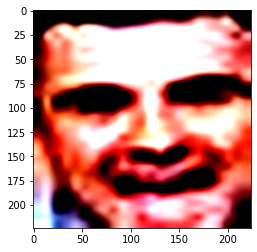

Female


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


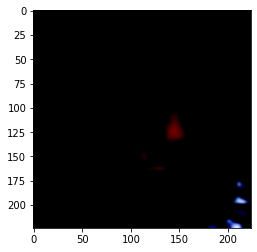

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


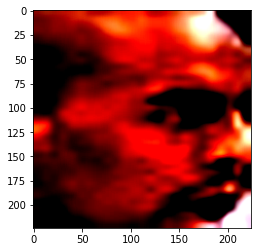

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


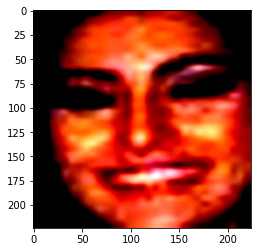

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


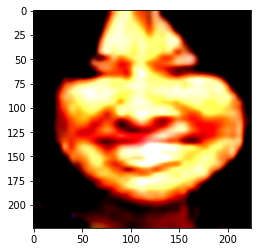

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


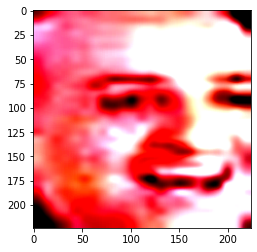

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


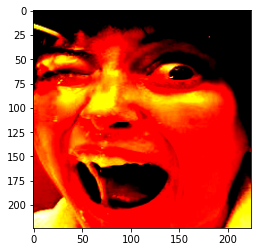

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


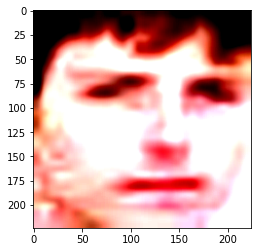

Female


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


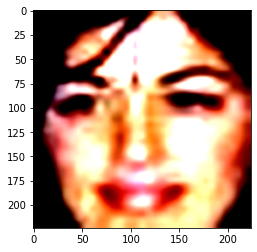

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


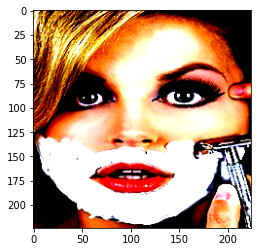

Female


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


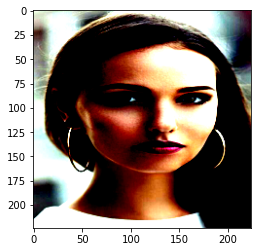

FileNotFoundError: ignored

In [26]:
# финальное предсказание, создержится в скрипте

def make_final_pred(model, dir):
  DIR = Path(dir)
  files = sorted(list(DIR.rglob('*.jpg')))
  fil = []
  preds = []
  for img in files:
    y_ = np.argmax(predict_one_sample(model, prepare_im(Path(img)).unsqueeze(0)), -1)
    fil.append(str(img))
    if y_[0] == 0:
      print('Female')
      preds.append('Female')
    else:
      print('Male')
      preds.append('Male')
    plt.imshow(prepare_im(Path(img)).numpy().transpose((1, 2, 0)))
    plt.show()
    
    data = dict(zip(fil, preds))

    with open("process_results.json", "w") as write_file:
      json.dump(data, write_file)


# with open("data_file.json") as write_file:
#   t = json.load(write_file)
#   print(t)

make_final_pred(simple_cnn, '/content/gdrive/My Drive/intership/test') 



with open("data_file.json") as write_file:
    t = json.load(write_file)

Предсказание на тестовой выборке

In [27]:
test_d.replace({'female':0, 'male':1},inplace=True)
imgs = [prepare_im(test_d.loc[id,'filename']).unsqueeze(0) for id in range(6000)]

probs_ims = predict(simple_cnn, imgs)

In [28]:
y_pred = np.argmax(probs_ims,-1)
# test_d.replace({'female':0, 'male':1},inplace=True)
actual_labels = [test_d.loc[id, 'label'] for id in range(6000)]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [29]:
# Подсчет метрик
warnings.simplefilter(action='ignore', category=FutureWarning)
print('f1_score - ', f1_score(actual_labels, y_pred))
print('accuracy - ', accuracy_score(actual_labels, y_pred))

f1_score -  0.9582714827643081
accuracy -  0.9578333333333333


In [30]:
torch.save(simple_cnn, 'simple_cnn.pth')

In [2]:
model_new = torch.load('/content/gdrive/My Drive/intership/simple_cnn.pth')

AttributeError: ignored